In [1]:
!pip freeze | grep -E "qiskit|mapomatic"

mapomatic==0.13.0
qiskit==1.3.1
qiskit-aer==0.16.0
qiskit-algorithms==0.3.1
qiskit-experiments==0.8.1
qiskit-ibm-experiment==0.4.8
qiskit-ibm-provider==0.11.0
qiskit-ibm-runtime==0.34.0
qiskit-machine-learning==0.8.2
qiskit-nature==0.7.2


In [ ]:
from qiskit_ibm_runtime.fake_provider.backends import (
    FakeKolkataV2,
    FakeWashingtonV2,
    FakeMumbaiV2,
    FakeNairobiV2,
)
from qiskit.circuit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator

import mapomatic as mm
import numpy as np

In [3]:
backends = [FakeKolkataV2(), FakeWashingtonV2(), FakeMumbaiV2(), FakeNairobiV2()]
backend = FakeMumbaiV2()
simulator = AerSimulator()

In [4]:
def construct_trotter_circuit(
    num_qubits: int, trotter_steps: int, seed=0
) -> QuantumCircuit:
    np.random.seed(seed)
    params = np.random.uniform(low=0.0, high=np.pi, size=(2,))
    trotter_layer = QuantumCircuit(num_qubits)
    trotter_layer.rx(params[0], range(num_qubits))

    for i in range(0, num_qubits, 2):
        trotter_layer.cx(i, i + 1)
        trotter_layer.rz(params[1], i + 1)
        trotter_layer.cx(i, i + 1)
    for i in range(1, num_qubits - 1, 2):
        trotter_layer.cx(i, i + 1)
        trotter_layer.rz(params[1], i + 1)
        trotter_layer.cx(1, i + 1)

    trotter_circuit = QuantumCircuit(num_qubits)
    for _ in range(trotter_steps):
        trotter_circuit = trotter_circuit.compose(trotter_layer)

    return trotter_circuit

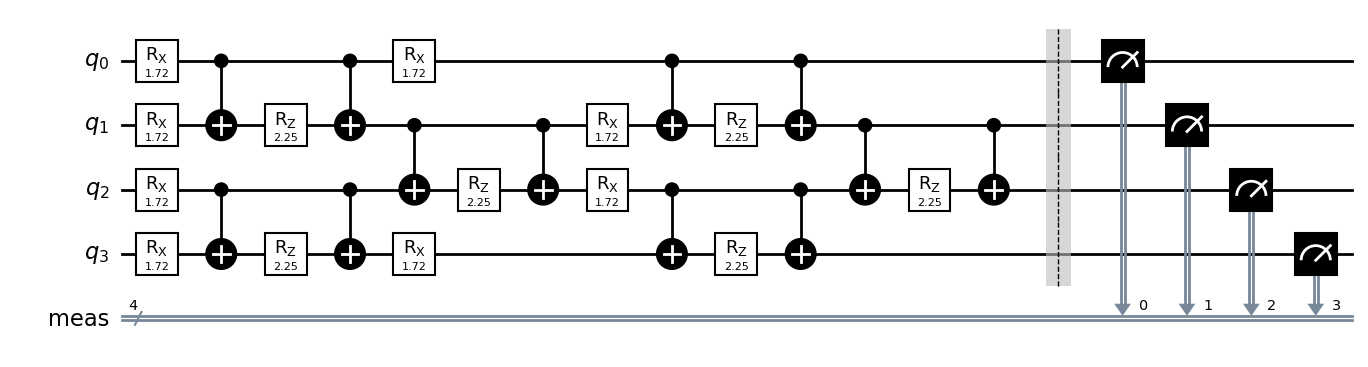

In [5]:
qc = construct_trotter_circuit(4, 2)
qc.measure_all()
qc.draw(output="mpl", idle_wires=False, style="bw", fold=-1)

In [6]:
def eval_expvals(counts: dict) -> float:
    shots = sum(counts.values())
    expval = 0

    for key, val in counts.items():
        parity = key.count("1")
        expval += (-1) ** parity * val / shots

    return expval

In [7]:
ideal_counts = simulator.run(qc, shots=10_000).result().get_counts()
ideal_expval = eval_expvals(ideal_counts)
ideal_expval

0.94

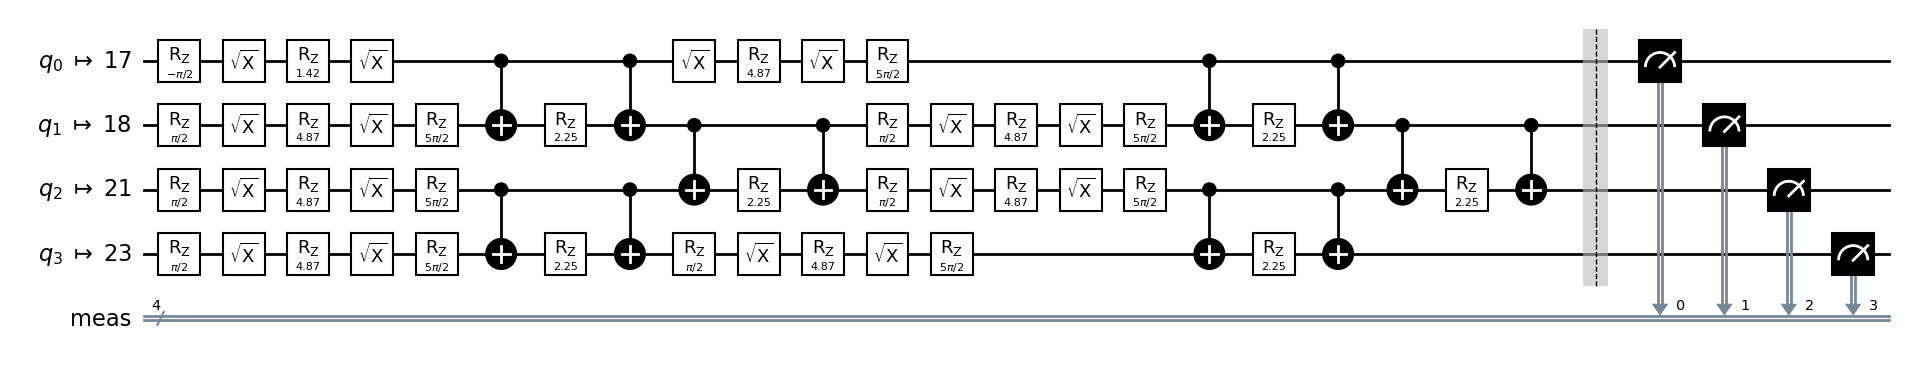

In [8]:
trans_qc = transpile(qc, backend=backend)
trans_qc.draw(output="mpl", idle_wires=False, style="bw", fold=-1)

In [9]:
noisy_counts = backend.run(qc, shots=10_000).result().get_counts()
noisy_expval = eval_expvals(noisy_counts)
noisy_expval

0.5341999999999999

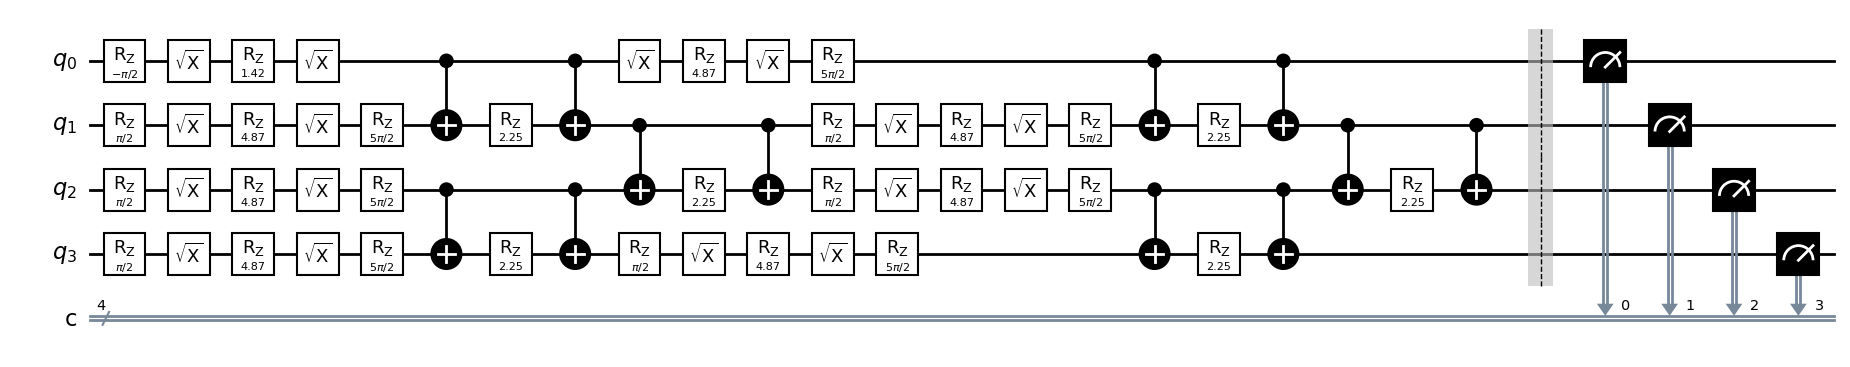

In [10]:
small_qc = mm.deflate_circuit(trans_qc)
small_qc.draw("mpl", style="bw", fold=-1, idle_wires=False)

In [11]:
layouts = mm.matching_layouts(small_qc, backend)
layouts

[[4, 1, 2, 3],
 [0, 1, 2, 3],
 [2, 1, 4, 7],
 [0, 1, 4, 7],
 [3, 2, 1, 4],
 [3, 2, 1, 0],
 [1, 2, 3, 5],
 [7, 4, 1, 2],
 [7, 4, 1, 0],
 [1, 4, 7, 10],
 [1, 4, 7, 6],
 [10, 7, 4, 1],
 [6, 7, 4, 1],
 [4, 7, 10, 12],
 [6, 7, 10, 12],
 [5, 3, 2, 1],
 [2, 3, 5, 8],
 [8, 5, 3, 2],
 [3, 5, 8, 11],
 [3, 5, 8, 9],
 [12, 10, 7, 4],
 [12, 10, 7, 6],
 [7, 10, 12, 13],
 [7, 10, 12, 15],
 [11, 8, 5, 3],
 [9, 8, 5, 3],
 [5, 8, 11, 14],
 [9, 8, 11, 14],
 [13, 12, 10, 7],
 [15, 12, 10, 7],
 [10, 12, 13, 14],
 [15, 12, 13, 14],
 [10, 12, 15, 18],
 [13, 12, 15, 18],
 [14, 11, 8, 5],
 [14, 11, 8, 9],
 [8, 11, 14, 13],
 [8, 11, 14, 16],
 [14, 13, 12, 10],
 [14, 13, 12, 15],
 [12, 13, 14, 11],
 [12, 13, 14, 16],
 [18, 15, 12, 10],
 [18, 15, 12, 13],
 [12, 15, 18, 21],
 [12, 15, 18, 17],
 [13, 14, 11, 8],
 [16, 14, 11, 8],
 [11, 14, 13, 12],
 [16, 14, 13, 12],
 [11, 14, 16, 19],
 [13, 14, 16, 19],
 [21, 18, 15, 12],
 [17, 18, 15, 12],
 [15, 18, 21, 23],
 [17, 18, 21, 23],
 [19, 16, 14, 11],
 [19, 16, 14, 13]

In [12]:
scores = mm.evaluate_layouts(small_qc, layouts, backend)
scores

[([23, 21, 18, 17], 0.16544673965337353),
 ([17, 18, 21, 23], 0.16544673965337364),
 ([19, 22, 25, 26], 0.16881896060166435),
 ([26, 25, 22, 19], 0.16881896060166435),
 ([25, 22, 19, 20], 0.17344018229882296),
 ([20, 19, 22, 25], 0.17344018229882308),
 ([4, 7, 10, 12], 0.17471568909032031),
 ([12, 10, 7, 4], 0.17471568909032031),
 ([24, 25, 22, 19], 0.17662342910386242),
 ([19, 22, 25, 24], 0.17662342910386275),
 ([6, 7, 4, 1], 0.17767110405222664),
 ([1, 4, 7, 6], 0.17767110405222675),
 ([1, 4, 7, 10], 0.1826380392018181),
 ([10, 7, 4, 1], 0.1826380392018181),
 ([24, 23, 21, 18], 0.18522452573992332),
 ([18, 21, 23, 24], 0.18522452573992343),
 ([16, 19, 22, 25], 0.18840097020299618),
 ([25, 22, 19, 16], 0.1884009702029963),
 ([6, 7, 10, 12], 0.19205576469727326),
 ([12, 10, 7, 6], 0.19205576469727326),
 ([26, 25, 24, 23], 0.1930430557737447),
 ([23, 24, 25, 26], 0.19304305577374492),
 ([13, 12, 10, 7], 0.19670342252748596),
 ([7, 10, 12, 13], 0.19670342252748607),
 ([25, 24, 23, 21], 

In [13]:
init_layout = scores[0][0]
circ = transpile(qc, backend=backend, initial_layout=init_layout)
mm_counts = backend.run(circ, shots=10_000).result().get_counts()
mm_expval = eval_expvals(mm_counts)
mm_expval

0.6859999999999999

In [14]:
backend.properties().gate_error("cx", (22, 19))

0.004661878013991871

In [15]:
all_layouts = mm.best_overall_layout(small_qc, backends, successors=True)
all_layouts

[([25, 24, 23, 21], 'fake_kolkata', 0.08917769410163545),
 ([50, 51, 36, 32], 'fake_washington', 0.11365959488953326),
 ([23, 21, 18, 17], 'fake_mumbai', 0.16544673965337353),
 ([5, 3, 1, 2], 'fake_nairobi', 0.17946740053388754)]

In [16]:
bnd = FakeKolkataV2()
circ_best = transpile(qc, backend=bnd, initial_layout=all_layouts[0][0])
best_counts = bnd.run(circ_best, shots=10_000).result().get_counts()
best_expval = eval_expvals(best_counts)
best_expval

0.7894000000000001